In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt

# Generate Synthetic House Price Data

In [ ]:
# Generate Synthetic data for house price
np.random.seed(42)
num_samples = 500

# Features: House size (sq ft) and location index
x = np.random.rand(num_samples, 2)*100

# True price eqn: price = 50 * size * 30 * Loaction * Noise
y = 50 * x[:, 0] + 30 * x[:, 1] + np.random.randn(num_samples) * 10
y = y.reshape(-1, 1)

# split into training and test sets
train_size = int(0.8 * num_samples)
x_train, x_test = x[:train_size], x[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

print(f"Training Samples: {x_train.shape}, Test Samples : {x_test.shape}")



Training Samples: (400, 2), Test Samples : (100, 2)


 **Define LoRA Layer**

 How This Works:

 W is fronzen (not updated during training)

 A and B are trained. capturing task-specific knowledge.

 The LoRA upadate A.B adapts the model with fewer parameters.

In [ ]:
class LoRALayer(tf.keras.layers.Layer):
    def __init__(self, input_dim, output_dim, rank=2, alpha=1.0):
        super(LoRALayer, self).__init__()
        self.rank = rank
        self.alpha = alpha  # Scaling factor

        # Main Frozen weights matrix
        self.W = self.add_weight(shape=(input_dim, output_dim), initializer="random_normal", trainable=False)

        # LoRA trainable low-rank matrices
        self.A = self.add_weight(shape=(input_dim, rank), initializer="random_normal", trainable=True)
        self.B = self.add_weight(shape=(rank, output_dim), initializer="random_normal", trainable=True)

    def call(self, inputs):
        lora_update = tf.matmul(inputs, self.A)
        lora_update = tf.matmul(lora_update, self.B) * self.alpha
        return tf.matmul(inputs, self.W) + lora_update  # W is frozen, only A and B update

# Build Regression Model with LoRA

Epoch 1/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 18989946.0000 - val_loss: 15635935.0000
Epoch 2/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 17558840.0000 - val_loss: 11860685.0000
Epoch 3/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 11465703.0000 - val_loss: 3234846.0000
Epoch 4/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1974308.8750 - val_loss: 207212.7969
Epoch 5/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 240723.9219 - val_loss: 114061.7812
Epoch 6/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 107737.7266 - val_loss: 79049.8281
Epoch 7/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 74347.8438 - val_loss: 51773.8359
Epoch 8/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 48116.1406 - val_loss: 32952.2891
Epoch 9/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 30659.9746 - val_loss: 20034.2539
Epoch 10/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 16620.6602 - val_loss: 11745.6465
Epoch 11/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5m

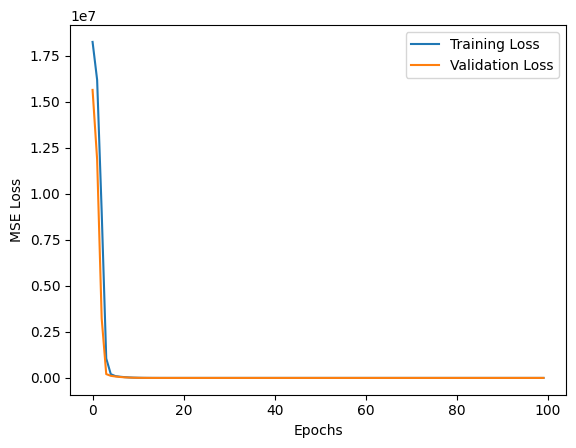

In [ ]:
# Define the model with LoRA
input_dim = x_train.shape[1]
output_dim = 1 # Predicting house price

inputs = keras.Input(shape=(input_dim,))
x = LoRALayer(input_dim, 16, rank=2, alpha=1.0)(inputs) # Lora applied here
x = layers.ReLU()(x)
x = layers.Dense(1)(x) # Final regression model
model = keras.Model(inputs, x)

# compile the model
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.01), loss="mse")

# Train the model

history = model.fit(x_train, y_train, epochs=100, batch_size=16, validation_data=(x_test, y_test), verbose=1)


# Evaluate on test data

test_loss = model.evaluate(x_test, y_test, verbose=0)
print(f"Test Loss (MSE): {test_loss}")


# Plot training loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('MSE Loss')
plt.legend()
plt.show()



Code to quantize and dequantize weights to and from 8bits. Used in QLora

In [1]:
# step 2: 4-bit quantization function

def quantize_4bit(weights):
  """"convert weights to 4-bit representation and store scale factor,"""
  min_w, max_w = np.min(weights), np.max(weights)
  scale = (max_w - min_w) / 15 # 2^4 - 1 = 15 levels in 4-bit
  quantized = np.round((weights - min_w) / scale).astype(np.int8) # store as int8
  return quantized, min_w, scale

def dequantize_4bit(quantized, min_w, scale):
  """Dequantized 4-bit weights back to floating point values."""
  return quantized * scale + min_w






